In [166]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_theme(style="darkgrid", rc={'figure.figsize': (9, 5)})

# Global stuff
df_boston = pd.read_csv('./data/boston_2015.csv',
                        dtype={'start_station_id': np.int64, 'end_station_id': 'string', 'end_station_name': 'string',
                               'start_station_name': 'string', 'bike_id': np.int64, 'user_type': 'string'})
df_boston['start_time'] = pd.to_datetime(df_boston['start_time'], format='%Y-%m-%d %X')
df_boston['end_time'] = pd.to_datetime(df_boston['end_time'], format='%Y-%m-%d %X')
df_boston.drop(index=df_boston.loc[df_boston["end_station_id"] == "\\N"].index, inplace=True, axis=1)
days = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
months = ['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November',
          'December']

point_of_day = ["morning", "afternoon", "evening", "night"]
morning_hours = [*range(6, 12)]
afternoon_hours = [*range(12, 18)]
evening = [*range(18, 23)]
night = [23] + [*range(0, 6)]


def get_point_of_day(hour):
    if hour in morning_hours:
        return "1_morning"
    elif hour in afternoon_hours:
        return "2_afternoon"
    elif hour in evening:
        return "3_evening"
    elif hour in night:
        return "4_night"

## General Overview of rentals per day over complete year

[Text(0.5, 0, 'Date'),
 Text(0, 0.5, 'Number of rides'),
 Text(0.5, 1.0, 'Rides per Day')]

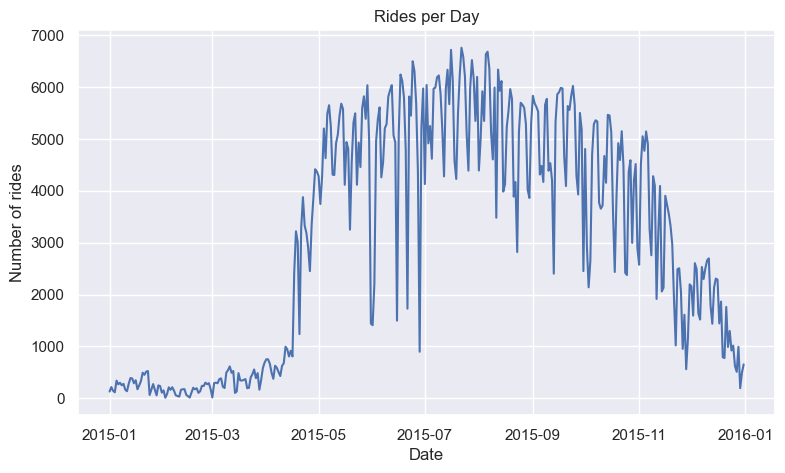

In [139]:
# Data
demand_series = df_boston.groupby(df_boston['start_time'].dt.date).size()
demand_series.index = pd.to_datetime(demand_series.index, format='%Y-%m-%d')

# Graph
ax = sns.lineplot(demand_series)
ax.set(xlabel='Date', ylabel='Number of rides', title='Rides per Day')


[Text(0.5, 0, 'Date'),
 Text(0, 0.5, 'Number of rides'),
 Text(0.5, 1.0, 'Rides per Week')]

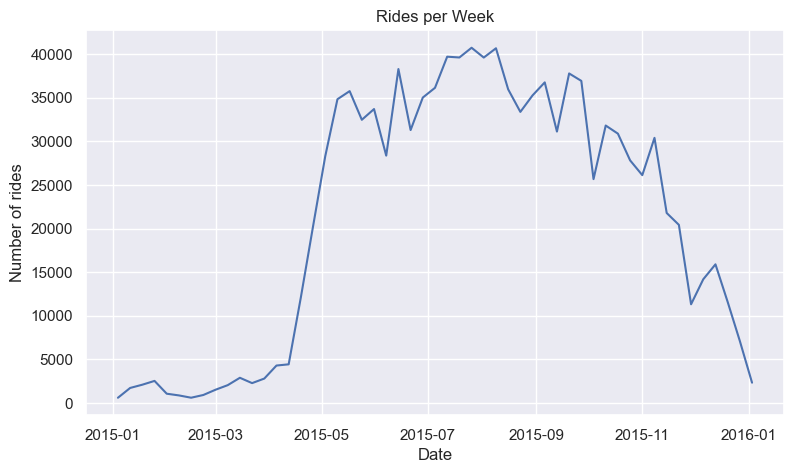

In [140]:
# Graph
ax = sns.lineplot(demand_series.resample('W').sum())
ax.set(xlabel='Date', ylabel='Number of rides', title='Rides per Week')

[Text(0.5, 0, 'Month of year 2015'),
 Text(0, 0.5, 'Number of rides'),
 Text(0.5, 1.0, 'Rides per Month')]

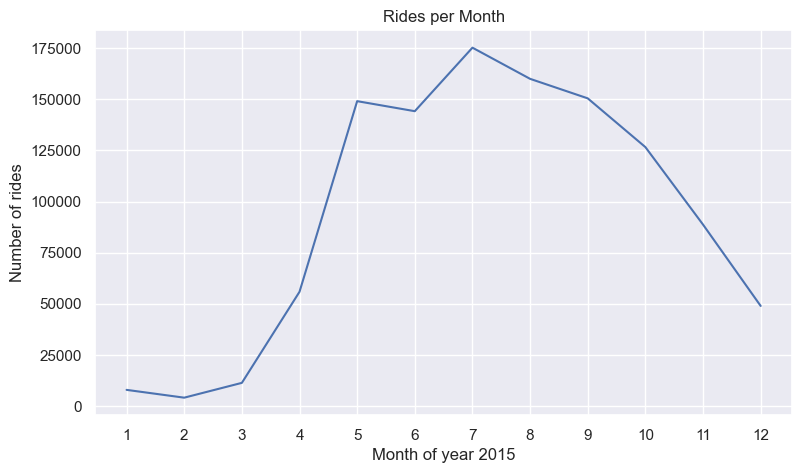

In [141]:
# Graph
demand_series_monthly = demand_series.resample('M').sum()
demand_series_monthly.index = list(range(1, 13))
ax = sns.lineplot(demand_series_monthly)
ax.set_xticks(demand_series_monthly.index)
ax.set(xlabel='Month of year 2015', ylabel='Number of rides', title='Rides per Month')

## Rentals per weekday over complete year

[Text(0.5, 0, 'Weekday'),
 Text(0, 0.5, 'Number of rides'),
 Text(0.5, 1.0, 'Rides per Month')]

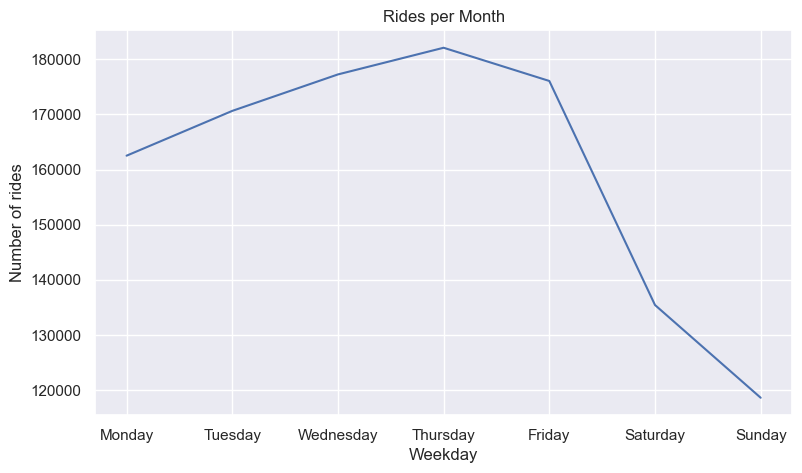

In [142]:
# Data
demand_weekday = df_boston.groupby(df_boston['start_time'].dt.day_name(), sort=True)
grouped_weekdays = demand_weekday.size().reindex(days)

# Graph
ax = sns.lineplot(grouped_weekdays)
ax.set_xticks(grouped_weekdays.index)
ax.set(xlabel='Weekday', ylabel='Number of rides', title='Rides per Month')

## Rentals per weekday over the year

<AxesSubplot: xlabel='Weekday', ylabel='num_rides'>

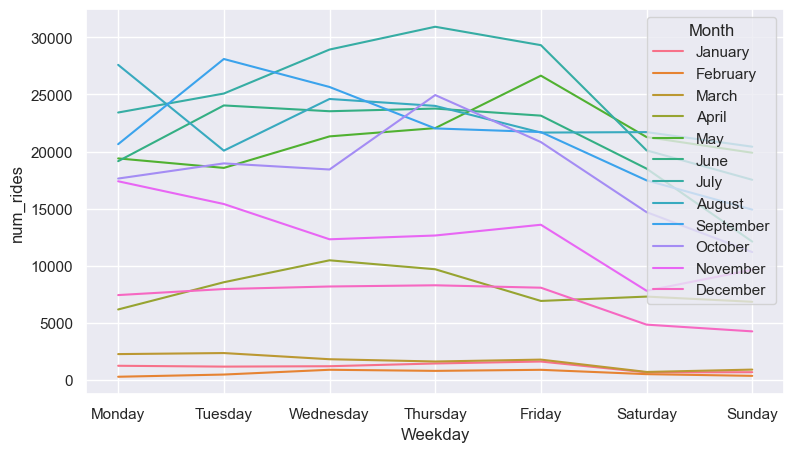

In [143]:
df_rentals_month_weekday = df_boston.copy()

# Add Column Month with the month of each ride
df_rentals_month_weekday['Month'] = df_rentals_month_weekday['start_time'].dt.month_name()

# Add Column Weekday with the weekday of each ride
df_rentals_month_weekday['Weekday'] = df_rentals_month_weekday['start_time'].dt.day_name()

# Group all rides of the year by Month and Weekday
df_rentals_month_weekday = df_rentals_month_weekday.groupby(['Month', 'Weekday']).size().reset_index(name='num_rides')

# Transform dtype from object to category
df_rentals_month_weekday.Weekday = pd.Categorical(df_rentals_month_weekday.Weekday, categories=days)
df_rentals_month_weekday = df_rentals_month_weekday.sort_values('Weekday')

# Transform dtype from object to category
df_rentals_month_weekday.Month = pd.Categorical(df_rentals_month_weekday.Month, categories=months)
df_rentals_month_weekday = df_rentals_month_weekday.sort_values('Month')

sns.lineplot(data=df_rentals_month_weekday, x='Weekday', y='num_rides', hue='Month')

## Rental by UserType by month

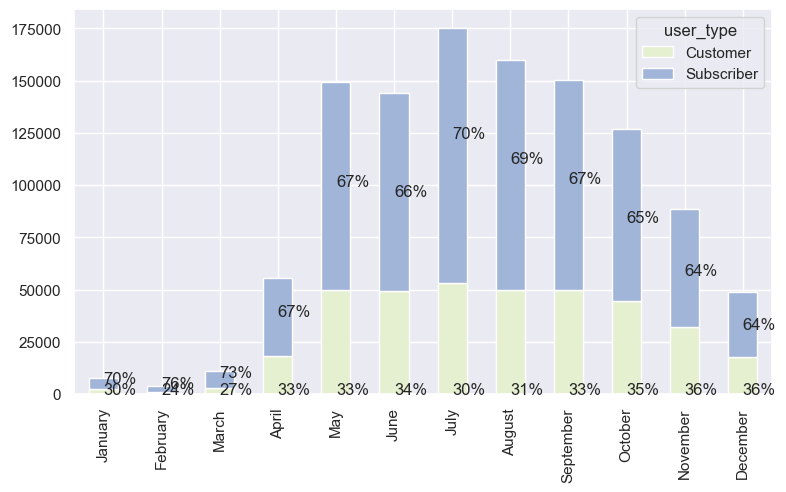

In [149]:
# Groups the rentals by month and usertype. Then the grouped pivot table is unstacked, so that every user_type gets a table in a dataframe
months_by_user_type = df_boston.groupby([df_boston["start_time"].dt.month, 'user_type']).size().unstack()
months_by_user_type.index = months

months_by_user_type.plot(kind='bar', stacked=True, color={'Subscriber': '#A1B5D8', 'Customer': '#E4F0D0'})

for index, row in months_by_user_type.iterrows():
    sum = row['Customer'] + row['Subscriber']

    plt.text(x=months.index(index), y=0, s=str(round(row['Customer'] / sum * 100)) + "%")
    plt.text(x=months.index(index), y=row['Subscriber'], s=str(round(row['Subscriber'] / sum * 100)) + "%")

## Rental by Point of Day

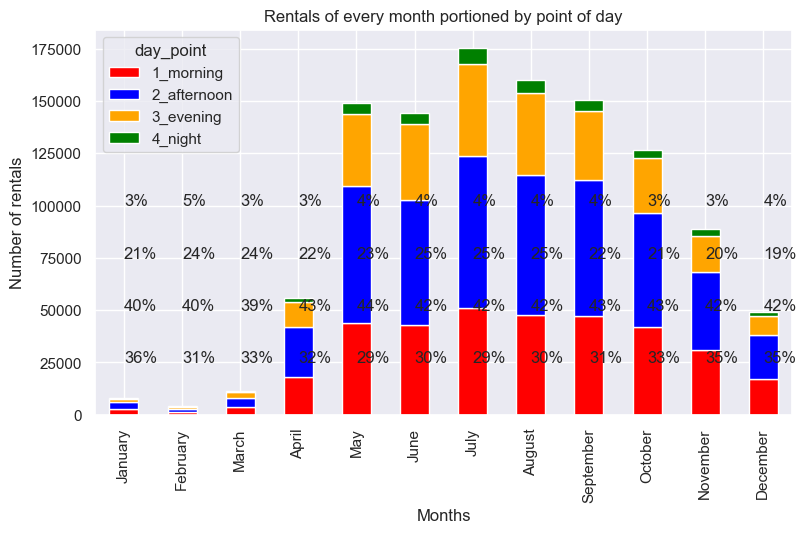

In [208]:
with_point_day = df_boston.copy()
with_point_day["day_point"] = with_point_day["start_time"].dt.hour.apply(lambda x: get_point_of_day(x))

with_point_day = with_point_day.groupby([df_boston["start_time"].dt.month, 'day_point']).size().unstack()
with_point_day.index = months

with_point_day.plot(kind='bar', stacked=True,
                    color={'1_morning': 'red', '2_afternoon': 'blue', '3_evening': 'orange', '4_night': 'green', })

# Graph props
plt.title("Rentals of every month portioned by point of day")
plt.xlabel("Months")
plt.ylabel("Number of rentals")

for index, row in with_point_day.iterrows():
    sum = row['1_morning'] + row['2_afternoon'] + row['3_evening'] + row['4_night']

    # The y values are constant, because the values in Febr. are so small, that the text would overlap when it's centered in the bars height
    plt.text(x=months.index(index), y=25000, s=str(round(row['1_morning'] / sum * 100)) + "%")
    plt.text(x=months.index(index), y=50000, s=str(round(row['2_afternoon'] / sum * 100)) + "%")
    plt.text(x=months.index(index), y=75000, s=str(round(row['3_evening'] / sum * 100)) + "%")
    plt.text(x=months.index(index), y=100000, s=str(round(row['4_night'] / sum * 100)) + "%")

Text(0, 0.5, 'Share of rentals in %')

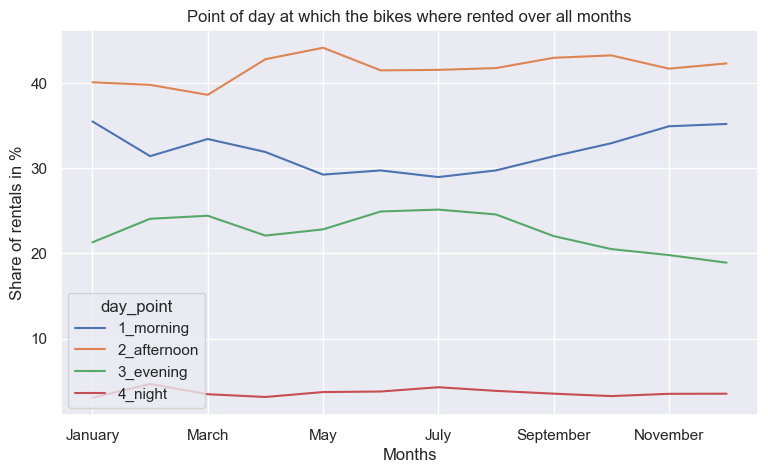

In [207]:
# For each value calculate the share by dividing the value by the sum of complete row
point_of_days_without_sum = with_point_day.loc[:, "1_morning":"4_night"].div(with_point_day.sum(axis=1), axis=0).mul(
    100)
point_of_days_without_sum.index = months
point_of_days_without_sum.plot(kind='line')

# Graph props
plt.title("Point of day at which the bikes where rented over all months")
plt.xlabel("Months")
plt.ylabel("Share of rentals in %")